In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
%cd '/content/drive/MyDrive/Colab Notebooks/Anamoly'

/content/drive/MyDrive/Colab Notebooks/Anamoly


In [16]:

import numpy as np
import matplotlib.pyplot as plt
import torch as T

device = T.device("cpu") 



In [17]:
class tensor_converter(T.utils.data.Dataset):
  # 8,12,0,16, . . 15,7
  # 64 pixel values [0-16], digit [0-9]

  def __init__(self, src_file, n_rows=None):
    all_xy = np.loadtxt(src_file, max_rows=n_rows,
      usecols=range(0,65), delimiter=",", comments="#",dtype=np.float32)
    self.xy_data = T.tensor(all_xy, dtype=T.float32).to(device) 
    self.xy_data[:, 0:64] /= 16.0   # normalize pixels
    self.xy_data[:, 64] /= 9.0      # normalize digit/label

  def __len__(self):
    return len(self.xy_data)

  def __getitem__(self, idx):
    xy = self.xy_data[idx]
    return xy



In [18]:
def display_digit(ds, idx, save=False):
  # ds is a PyTorch Dataset
  line = ds[idx]  # tensor
  pixels = np.array(line[0:64])  # numpy row of pixels
  label = np.int(line[64] * 9.0)  # denormalize; like '5'
  print("\ndigit = ", str(label), "\n")

  pixels = pixels.reshape((8,8))
  for i in range(8):
    for j in range(8):
      pxl = pixels[i,j]  # or [i][j] syntax
      pxl = np.int(pxl * 16.0)  # denormalize
      print("%.2X" % pxl, end="")
      print(" ", end="")
    print("")

  plt.imshow(pixels, cmap=plt.get_cmap('gray_r'))
  if save == True:
    plt.savefig(".\\idx_" + str(idx) + "_digit_" + \
                str(label) + ".jpg", bbox_inches='tight')
  plt.show() 
  plt.close() 


In [19]:
def display_digits(ds, idxs, save=False):
  # idxs is a list of indices
  for idx in idxs:
    display_digit(ds, idx, save)

# -----------------------------------------------------------

class Autoencoder(T.nn.Module):  

  def __init__(self):
    super(Autoencoder, self).__init__()
    self.fc1 = T.nn.Linear(65, 48)
    self.fc2 = T.nn.Linear(48, 32)
    self.fc3 = T.nn.Linear(32, 8)
    self.fc4 = T.nn.Linear(8, 32)
    self.fc5 = T.nn.Linear(32, 48)
    self.fc6 = T.nn.Linear(48, 65)

  def encode(self, x):  
    # 65-48-32-8
    z = T.tanh(self.fc1(x))
    z = T.tanh(self.fc2(z))
    z = T.tanh(self.fc3(z)) 
    return z  

  def decode(self, x):  
    # 8-32-48-65
    z = T.tanh(self.fc4(x))
    z = T.tanh(self.fc5(z))
    z = T.sigmoid(self.fc6(z))
    return z
    
  def forward(self, x):
    z = self.encode(x) 
    z = self.decode(z) 
    return z  # in [0.0, 1.0]



In [20]:
def train(ae, ds, bs, me, le, lr):
  # autoencoder, dataset, batch_size, max_epochs,
  # log_every, learn_rate
  # assumes ae.train() has been set
  data_ldr = T.utils.data.DataLoader(ds, batch_size=bs,
    shuffle=True)
  loss_func = T.nn.MSELoss()
  opt = T.optim.SGD(ae.parameters(), lr=lr)
  print("\nStarting training")
  for epoch in range(0, me):
    epoch_loss = 0.0
    for (batch_idx, batch) in enumerate(data_ldr):
      X = batch  # inputs
      Y = batch  # targets (same as inputs)

      opt.zero_grad()                # prepare gradients
      oupt = ae(X)                   # compute output/target
      loss_val = loss_func(oupt, Y)  # a tensor
      epoch_loss += loss_val.item()  # accumulate for display
      loss_val.backward()            # compute gradients
      opt.step()                     # update weights

    if epoch % le == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
  print("Done ")



In [21]:
def make_err_list(model, ds):
  # assumes model.eval()
  result_lst = []
  n_features = len(ds[0])  # 65
  for i in range(len(ds)):
    X = ds[i]
    with T.no_grad():
      Y = model(X)  # should be same as X
    err = T.sum((X-Y)*(X-Y)).item()  # SSE all features
    err = err / n_features           # sort of norm'ed SSE 
    result_lst.append( (i,err) )     # idx of data item, err
  return result_lst 


In [31]:
def main():
  T.manual_seed(1)
  np.random.seed(1)

  # Step 1
  # Creating Dataset object
  print("\nLoad csv data, convert to  data as normalized tensors ")

  #Load .csv dataset containing 65 values
  #first 64 represetnts 64 pixels values in greyscale format
  #last 1 value represent actual digit (in between 0 to 9)
  csv_data = "hand_written_digits.txt"

  #Convert the csv format to a normalized tensors using helper function "tensor_converter"
  tensor_data = tensor_converter(csv_data)  



  # Step 2. Create autoencoder net
  print("\nCreating a 65-48-32-8-32-48-65 autoencoder ")
  autoenc = Autoencoder().to(device)
  autoenc.train()   

  # Step 3. Train autoencoder model
  batch_size = 10
  max_epochs = 100
  log_interval = 10
  learning_rate = 0.005

  print("\nBatch_size = %3d " % batch_size)
  print("Maximum epochs = " + str(max_epochs))
  print("Loss metric = MSELoss")
  print("Optimizer = SGD")
  print("lrn_rate = %0.3f " % learning_rate)

  train(autoenc,tensor_data, batch_size, max_epochs, \
    log_interval, learning_rate) 

  # 4. compute and store reconstruction errors
  print("\nComputing reconstruction errors ")
  
  #Set autoencoder mode for evaluation
  autoenc.eval()

  #Store the reconstruction MSE loss 
  MSE_list = make_err_list(autoenc, tensor_data)
  #Sort the list based on MSE loss from highest to lowest
  MSE_list.sort(key=lambda x: x[1], reverse=True)  
 

  # Step 5. Show most anomalous hand writen digit in the dataset
  print("Anomaly digit in the dataset given based on Highest MSE: ")
  (idx,MSE) = MSE_list[0]
  print(" Index : %4d , MSE : %0.4f" % (idx, MSE)) 
  display_digit(tensor_data, idx)






Load csv data, convert to  data as normalized tensors 

Creating a 65-48-32-8-32-48-65 autoencoder 

Batch_size =  10 
Maximum epochs = 100
Loss metric = MSELoss
Optimizer = SGD
lrn_rate = 0.005 

Starting training
epoch =    0   loss = 67.1019
epoch =   10   loss = 55.6212
epoch =   20   loss = 41.4885
epoch =   30   loss = 33.6646
epoch =   40   loss = 30.9021
epoch =   50   loss = 29.8265
epoch =   60   loss = 29.3423
epoch =   70   loss = 29.0789
epoch =   80   loss = 28.8988
epoch =   90   loss = 28.7914
Done 

Computing reconstruction errors 
Anomaly digit in the dataset given based on Highest MSE: 
 Index :  486 , MSE : 0.1360

digit =  7 

00 00 00 0A 10 10 10 09 
00 00 00 02 05 0A 10 0C 
00 00 00 00 00 06 10 02 
00 00 00 00 00 0E 0A 00 
00 01 08 0E 10 10 05 00 
00 05 0A 08 10 0A 01 00 
00 00 00 05 0E 01 00 00 
00 00 00 0D 09 00 00 00 


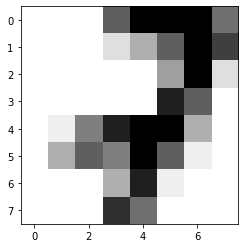

In [32]:
if __name__ == "__main__":
  main()